In [7]:
import torch
import json
import numpy as np
import pandas as pd
import os


#representation_path="/n/home12/cfpark00/WM_1/data/experiments/ft_atlantis_lowerlr_120k_mixed/analysis/probe2_train_all_l456/representations/checkpoint-4690/"
representation_path="/n/home12/cfpark00/WM_1/data/experiments/dist_1M_with_atlantis_15epochs_lowerlr/analysis/probe2_train_all_l456/representations/checkpoint-117195/"
#representation_path="/n/home12/cfpark00/WM_1/data/experiments/dist_1M_with_atlantis_15epochs_lowerlr_pad/analysis/probe2_train_all_l456/representations/checkpoint-82040"

repr_path=os.path.join(representation_path,"representations.pt")
meta_path=os.path.join(representation_path,"metadata.json")

data = torch.load(repr_path)
with open(meta_path, 'r') as f:
    metadata = json.load(f)

representations = data['representations'].numpy().reshape(-1,3,3,128)[:,0,-1,:]
city_info = metadata['city_info']
n_train = metadata['n_train_cities']

train_repr = representations[:n_train]
test_repr = representations[n_train:]
train_cities = city_info[:n_train]
test_cities = city_info[n_train:]

print(f'Train: {train_repr.shape}, Test: {test_repr.shape}')
print(f'Regions: {set([c["region"] for c in city_info if c["region"]])}')

Train: (3000, 128), Test: (2000, 128)
Regions: {'Eastern Europe', 'India', 'Korea', 'South America', 'Central Asia', 'Southeast Asia', 'China', 'Japan', 'Atlantis', 'Africa', 'North America', 'Western Europe', 'Middle East', 'Oceania'}


In [8]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from collections import defaultdict
import numpy as np
import os

# Compute PCA with 3 components for 3D visualization
pca_3d = PCA(n_components=3)
repr_pca_3d = pca_3d.fit_transform(representations)

# Get all unique regions (excluding None)
regions = sorted(set(c.get("region") for c in city_info if c.get("region") is not None))

# Assign colors to regions
import plotly.express as px
colors = px.colors.qualitative.Plotly + px.colors.qualitative.D3 + px.colors.qualitative.G10
region_to_color = {region: colors[i % len(colors)] for i, region in enumerate(regions)}

# Prepare data for each region
region_indices = defaultdict(list)
for i, c in enumerate(city_info):
    region = c.get("region")
    if region is not None:
        region_indices[region].append(i)

# Create 3D scatter plot
fig = go.Figure()

for region in regions:
    idxs = region_indices[region]
    
    # Add hover text with city names
    hover_text = [city_info[i]['name'] for i in idxs]
    
    fig.add_trace(go.Scatter3d(
        x=[repr_pca_3d[i, 0] for i in idxs],
        y=[repr_pca_3d[i, 1] for i in idxs],
        z=[repr_pca_3d[i, 2] for i in idxs],
        mode='markers',
        name=region,
        text=hover_text,
        hovertemplate='%{text}<br>Region: ' + region + '<br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}',
        marker=dict(
            size=4,
            color=region_to_color[region],
            opacity=0.8
        )
    ))

# Update layout
fig.update_layout(
    title='3D PCA of City Representations by Region',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=1000,
    height=800,
    legend=dict(
        x=1.02,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Save to HTML
output_dir = representation_path
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'pca_3d_regions.html')
fig.write_html(output_path)
print(f"3D PCA plot saved to: {output_path}")

# Print variance explained
variance_explained = pca_3d.explained_variance_ratio_
print(f"\nVariance explained by components:")
print(f"  PC1: {variance_explained[0]:.2%}")
print(f"  PC2: {variance_explained[1]:.2%}")
print(f"  PC3: {variance_explained[2]:.2%}")
print(f"  Total: {sum(variance_explained):.2%}")

3D PCA plot saved to: /n/home12/cfpark00/WM_1/data/experiments/dist_1M_with_atlantis_15epochs_lowerlr/analysis/probe2_train_all_l456/representations/checkpoint-117195/pca_3d_regions.html

Variance explained by components:
  PC1: 46.03%
  PC2: 20.77%
  PC3: 12.36%
  Total: 79.16%


In [11]:
128*3*3

1152

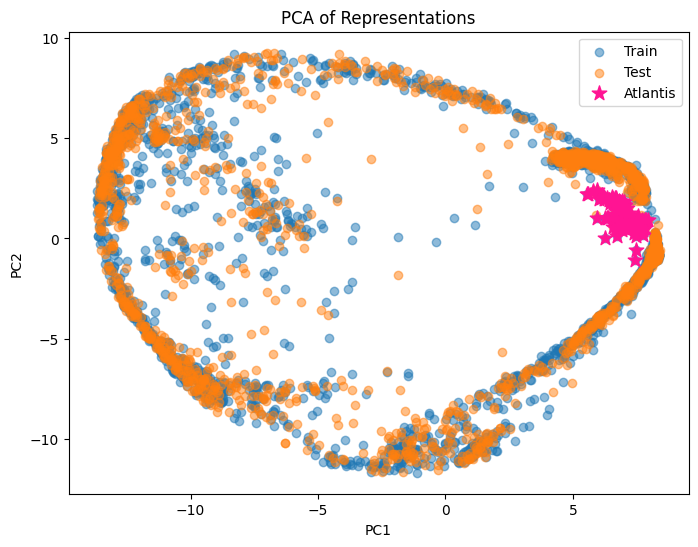

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Find indices of cities with region "Atlantis"
atlantis_indices = [i for i, c in enumerate(city_info) if c.get("region") == "Atlantis"]

# Compute PCA on all representations
pca = PCA(n_components=2)
repr_pca = pca.fit_transform(representations)

# Plot the PCA
plt.figure(figsize=(8,6))
plt.scatter(repr_pca[:n_train, 0], repr_pca[:n_train, 1], label='Train', alpha=0.5)
plt.scatter(repr_pca[n_train:, 0], repr_pca[n_train:, 1], label='Test', alpha=0.5)

# Overlay Atlantis cities as pink stars
if atlantis_indices:
    plt.scatter(
        repr_pca[atlantis_indices, 0],
        repr_pca[atlantis_indices, 1],
        color='#FF1493',
        marker='*',
        s=120,
        label='Atlantis'
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Representations')
plt.legend()
plt.show()

/tmp/ipykernel_498122/821741827.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(regions))


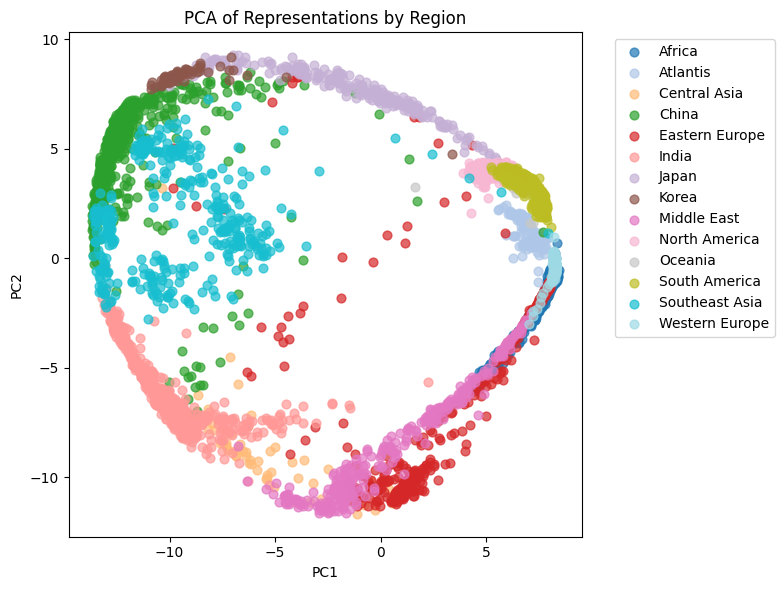

In [13]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Get all unique regions (excluding None)
regions = sorted(set(c.get("region") for c in city_info if c.get("region") is not None))

# Assign a color to each region using a colormap
import matplotlib.cm as cm
import numpy as np

cmap = cm.get_cmap('tab20', len(regions))
region_to_color = {region: cmap(i) for i, region in enumerate(regions)}

# Prepare data for each region
region_indices = defaultdict(list)
for i, c in enumerate(city_info):
    region = c.get("region")
    if region is not None:
        region_indices[region].append(i)

plt.figure(figsize=(8,6))
for region in regions:
    idxs = region_indices[region]
    plt.scatter(
        [repr_pca[i, 0] for i in idxs],
        [repr_pca[i, 1] for i in idxs],
        color=region_to_color[region],
        label=region,
        alpha=0.7,
        s=40
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Representations by Region')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [14]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from collections import defaultdict
import numpy as np
import os

# Compute PCA with 3 components for 3D visualization
pca_3d = PCA(n_components=3)
repr_pca_3d = pca_3d.fit_transform(representations)

# Get all unique regions (excluding None)
regions = sorted(set(c.get("region") for c in city_info if c.get("region") is not None))

# Assign colors to regions
import plotly.express as px
colors = px.colors.qualitative.Plotly + px.colors.qualitative.D3 + px.colors.qualitative.G10
region_to_color = {region: colors[i % len(colors)] for i, region in enumerate(regions)}

# Prepare data for each region
region_indices = defaultdict(list)
for i, c in enumerate(city_info):
    region = c.get("region")
    if region is not None:
        region_indices[region].append(i)

# Create 3D scatter plot
fig = go.Figure()

for region in regions:
    idxs = region_indices[region]
    
    # Add hover text with city names
    hover_text = [city_info[i]['name'] for i in idxs]
    
    fig.add_trace(go.Scatter3d(
        x=[repr_pca_3d[i, 0] for i in idxs],
        y=[repr_pca_3d[i, 1] for i in idxs],
        z=[repr_pca_3d[i, 2] for i in idxs],
        mode='markers',
        name=region,
        text=hover_text,
        hovertemplate='%{text}<br>Region: ' + region + '<br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}',
        marker=dict(
            size=4,
            color=region_to_color[region],
            opacity=0.8
        )
    ))

# Update layout
fig.update_layout(
    title='3D PCA of City Representations by Region',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=1000,
    height=800,
    legend=dict(
        x=1.02,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Save to HTML
output_dir = representation_path
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'pca_3d_regions.html')
fig.write_html(output_path)
print(f"3D PCA plot saved to: {output_path}")

# Print variance explained
variance_explained = pca_3d.explained_variance_ratio_
print(f"\nVariance explained by components:")
print(f"  PC1: {variance_explained[0]:.2%}")
print(f"  PC2: {variance_explained[1]:.2%}")
print(f"  PC3: {variance_explained[2]:.2%}")
print(f"  Total: {sum(variance_explained):.2%}")

3D PCA plot saved to: /n/home12/cfpark00/WM_1/data/experiments/dist_1M_with_atlantis_15epochs_lowerlr/analysis/probe2_train_all_l456/representations/checkpoint-117195/pca_3d_regions.html

Variance explained by components:
  PC1: 50.95%
  PC2: 19.14%
  PC3: 9.28%
  Total: 79.37%


In [28]:
import pandas as pd

# Load the cities.csv file
cities_csv_path = "/n/home12/cfpark00/WM_1/data/datasets/cities/cities.csv"
cities_df = pd.read_csv(cities_csv_path)

# Build a set of asciiname from the csv for fast lookup
csv_city_names = set(cities_df['asciiname'])

# Build a dict mapping asciiname to (x, y) from the csv
csv_city_xy = {row['asciiname']: (row['x'], row['y']) for _, row in cities_df.iterrows()}

# Get all city names from city_info (using whatever key is present, e.g. 'name')
data_city_names = set(c['name'] for c in city_info)

# Check that all cities in our data exist in the csv
missing_in_csv = data_city_names - csv_city_names
if missing_in_csv:
    print(f"Cities in data but missing from csv: {missing_in_csv}")
else:
    print("All cities in data exist in the csv.")

# Check that all cities in our data have x and y in the csv
missing_xy = []
for c in city_info:
    name = c['name']
    if name in csv_city_xy:
        x, y = csv_city_xy[name]
        if pd.isnull(x) or pd.isnull(y):
            missing_xy.append(name)
    else:
        # Already reported above
        continue

if missing_xy:
    print(f"Cities in csv but missing x or y: {missing_xy}")
else:
    print("All cities in data have corresponding x, y in the csv.")


All cities in data exist in the csv.
All cities in data have corresponding x, y in the csv.


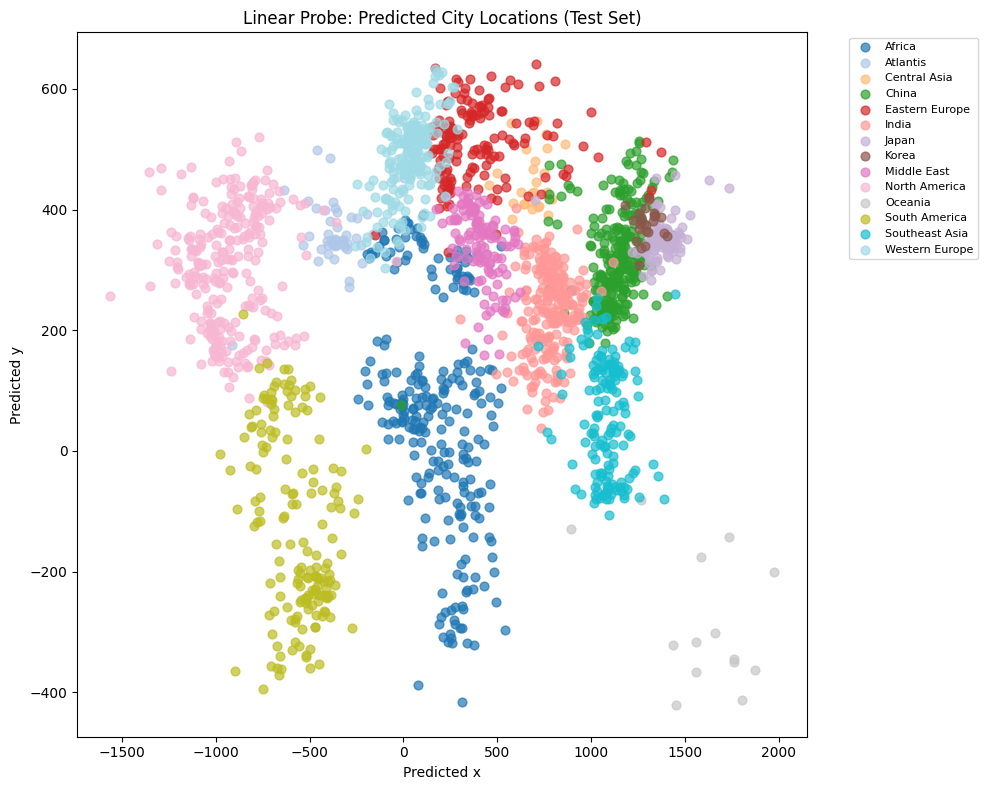


R² score: 0.9491


In [29]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Get x,y coordinates for all cities
city_xy = np.array([csv_city_xy[c['name']] for c in city_info])

# We already have representations loaded as 'representations' and split into train/test
# Train linear probe on train set
probe = LinearRegression()
probe.fit(train_repr, city_xy[:n_train])

# Predict on test set
y_pred = probe.predict(test_repr)
y_true = city_xy[n_train:]

# Get regions for test cities
test_regions = [c.get('region', 'Unknown') for c in test_cities]

# Plot predicted x, y for test set, colored by region
plt.figure(figsize=(10, 8))
unique_regions = sorted(set(test_regions))
region_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_regions)))
region_to_color = dict(zip(unique_regions, region_colors))

for region in unique_regions:
    idxs = [i for i, r in enumerate(test_regions) if r == region]
    if idxs:
        plt.scatter(
            y_pred[idxs, 0], y_pred[idxs, 1],
            label=region,
            color=region_to_color[region],
            alpha=0.7,
            s=40
        )

plt.xlabel("Predicted x")
plt.ylabel("Predicted y")
plt.title("Linear Probe: Predicted City Locations (Test Set)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Calculate and print R² score
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"\nR² score: {r2:.4f}")

LDA Test Accuracy: 0.9210
Max LDA components: 13 (from 14 classes)

Classification Report:
                precision    recall  f1-score   support

        Africa       0.93      0.94      0.93       261
      Atlantis       0.93      0.93      0.93        44
  Central Asia       0.67      0.74      0.70        27
         China       0.94      0.89      0.92       259
Eastern Europe       0.82      0.85      0.83       155
         India       0.95      0.97      0.96       227
         Japan       0.99      0.91      0.95        96
         Korea       0.47      0.83      0.60        23
   Middle East       0.84      0.83      0.83       118
 North America       0.99      0.97      0.98       260
       Oceania       1.00      0.86      0.92        14
 South America       0.95      0.98      0.97       169
Southeast Asia       0.95      0.93      0.94       152
Western Europe       0.93      0.90      0.92       195

      accuracy                           0.92      2000
     macro 

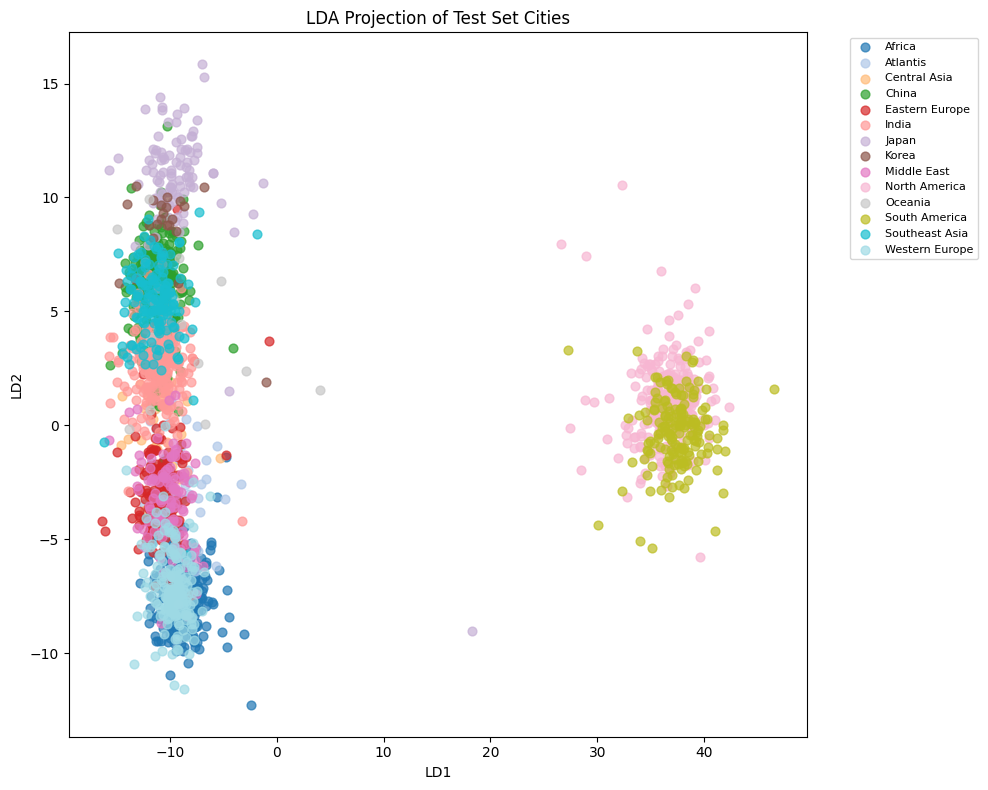

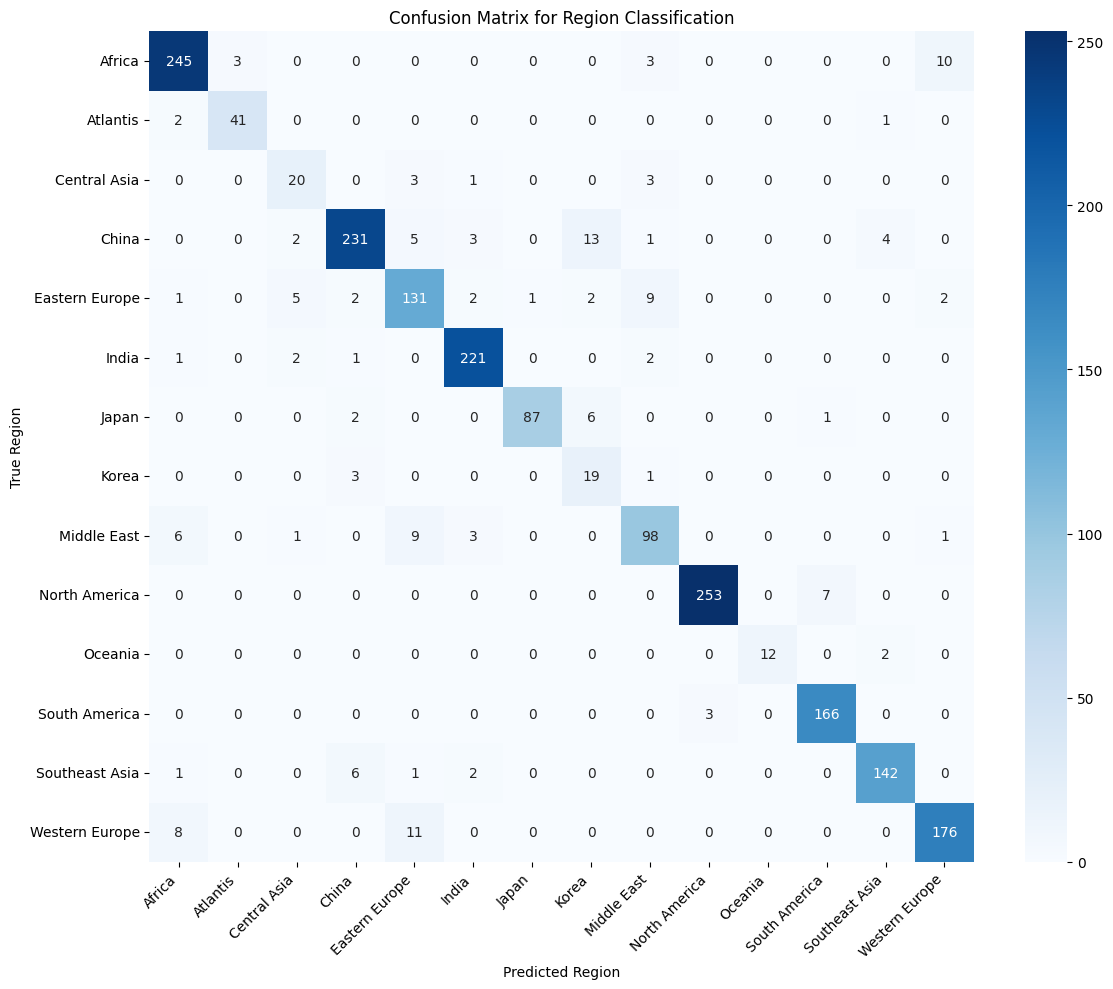


Misclassified cities (showing first 10):
  Atyrau: Central Asia -> Eastern Europe
  Saga: Japan -> Korea
  Relizane: Africa -> Western Europe
  Kingston: North America -> South America
  Karatsu: Japan -> Korea
  Dunhua: China -> Korea
  Ta'if: Middle East -> Africa
  Tangier: Africa -> Western Europe
  Malaga: Western Europe -> Africa
  Konya: Middle East -> Africa


In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data for LDA - filter out cities without regions
train_regions = [c.get('region') for c in train_cities]
test_regions = [c.get('region') for c in test_cities]

# Filter out None regions
train_mask = [r is not None for r in train_regions]
test_mask = [r is not None for r in test_regions]

X_train_lda = train_repr[train_mask]
y_train_lda = [r for r in train_regions if r is not None]

X_test_lda = test_repr[test_mask]
y_test_lda = [r for r in test_regions if r is not None]

# Train LDA - let it determine optimal number of components
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_lda, y_train_lda)

# Predict on test set
y_pred_lda = lda.predict(X_test_lda)

# Calculate accuracy
accuracy = lda.score(X_test_lda, y_test_lda)
print(f"LDA Test Accuracy: {accuracy:.4f}")

# Get number of unique classes and features to understand LDA dimensions
n_classes = len(np.unique(y_train_lda))
n_features = X_train_lda.shape[1]
max_components = min(n_classes - 1, n_features)
print(f"Max LDA components: {max_components} (from {n_classes} classes)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_lda, y_pred_lda))

# Transform data to LDA space for visualization
X_lda = lda.transform(test_repr[test_mask])
print(f"LDA transformed shape: {X_lda.shape}")

# Plot first 2 LDA components
plt.figure(figsize=(10, 8))
unique_regions = sorted(set(y_test_lda))
region_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_regions)))
region_to_color = dict(zip(unique_regions, region_colors))

for region in unique_regions:
    idxs = [i for i, r in enumerate(y_test_lda) if r == region]
    if idxs:
        plt.scatter(
            X_lda[idxs, 0], X_lda[idxs, 1],
            label=region,
            color=region_to_color[region],
            alpha=0.7,
            s=40
        )

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA Projection of Test Set Cities")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_lda, y_pred_lda, labels=unique_regions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_regions, yticklabels=unique_regions)
plt.title('Confusion Matrix for Region Classification')
plt.xlabel('Predicted Region')
plt.ylabel('True Region')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show misclassified examples
misclassified = [(test_cities[i]['name'], y_test_lda[i], y_pred_lda[i]) 
                 for i in range(len(y_test_lda)) if y_test_lda[i] != y_pred_lda[i]]
if misclassified:
    print(f"\nMisclassified cities (showing first 10):")
    for name, true, pred in misclassified[:10]:
        print(f"  {name}: {true} -> {pred}")

In [14]:
import plotly.graph_objects as go
import os

# Configure which LDA components to use for x, y, z axes
dims_to_use = [0,1,2]  # Change these indices to use different components (0-indexed)
# For example: [1, 2, 3] would use LD2, LD3, LD4 instead of LD1, LD2, LD3

# Transform both train and test data to LDA space for 3D visualization
X_train_lda_3d = lda.transform(train_repr[train_mask])
X_test_lda_3d = lda.transform(test_repr[test_mask])

# Combine for full visualization
X_all_lda = np.vstack([X_train_lda_3d, X_test_lda_3d])
all_regions = y_train_lda + y_test_lda
all_cities = [c for c, m in zip(train_cities + test_cities, train_mask + test_mask) if m]
all_splits = ['train'] * len(y_train_lda) + ['test'] * len(y_test_lda)

# Check if requested dimensions are available
max_dim = max(dims_to_use)
if max_dim >= X_all_lda.shape[1]:
    print(f"Warning: Requested dimension {max_dim} but only {X_all_lda.shape[1]} components available")
    print(f"Using 0 for missing dimensions")

# Get the components for each axis
def get_component(data, dim_idx):
    if dim_idx < data.shape[1]:
        return data[:, dim_idx]
    else:
        return np.zeros(data.shape[0])

# Create 3D scatter plot
fig = go.Figure()

# Get unique regions and assign colors
unique_regions = sorted(set(all_regions))
import plotly.express as px
colors = px.colors.qualitative.Plotly + px.colors.qualitative.D3 + px.colors.qualitative.G10
region_to_color = {region: colors[i % len(colors)] for i, region in enumerate(unique_regions)}

# Plot each region
for region in unique_regions:
    idxs = [i for i, r in enumerate(all_regions) if r == region]
    
    # Add hover text with city names and train/test split
    hover_text = [f"{all_cities[i]['name']} ({all_splits[i]})" for i in idxs]
    
    fig.add_trace(go.Scatter3d(
        x=[get_component(X_all_lda, dims_to_use[0])[i] for i in idxs],
        y=[get_component(X_all_lda, dims_to_use[1])[i] for i in idxs],
        z=[get_component(X_all_lda, dims_to_use[2])[i] for i in idxs],
        mode='markers',
        name=region,
        text=hover_text,
        hovertemplate=f'%{{text}}<br>Region: {region}<br>LD{dims_to_use[0]+1}: %{{x:.2f}}<br>LD{dims_to_use[1]+1}: %{{y:.2f}}<br>LD{dims_to_use[2]+1}: %{{z:.2f}}',
        marker=dict(
            size=4,
            color=region_to_color[region],
            opacity=0.8
        )
    ))

# Update layout with correct axis labels
fig.update_layout(
    title=f'3D LDA Projection of Cities by Region (Components {dims_to_use[0]+1}, {dims_to_use[1]+1}, {dims_to_use[2]+1})',
    scene=dict(
        xaxis_title=f'LD{dims_to_use[0]+1}',
        yaxis_title=f'LD{dims_to_use[1]+1}',
        zaxis_title=f'LD{dims_to_use[2]+1}'
    ),
    width=1000,
    height=800,
    legend=dict(
        x=1.02,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Save to HTML with filename indicating which components
output_dir = representation_path
os.makedirs(output_dir, exist_ok=True)
output_filename = f'lda_3d_regions_LD{dims_to_use[0]+1}_{dims_to_use[1]+1}_{dims_to_use[2]+1}.html'
output_path = os.path.join(output_dir, output_filename)
fig.write_html(output_path)
print(f"3D LDA plot saved to: {output_path}")

# Print info about LDA components
print(f"Using LDA components: LD{dims_to_use[0]+1}, LD{dims_to_use[1]+1}, LD{dims_to_use[2]+1}")
print(f"Total LDA components available: {X_all_lda.shape[1]}")

3D LDA plot saved to: /n/home12/cfpark00/WM_1/data/experiments/ft_atlantis_120k_mixed/analysis/probe2_train_all_l456/representations/checkpoint-4690/lda_3d_regions_LD1_2_3.html
Using LDA components: LD1, LD2, LD3
Total LDA components available: 13


In [4]:
import datasets
import numpy as np
import json
import matplotlib
import tqdm

ds=datasets.load_from_disk("./data/datasets/dist_1M_with_atlantis/")
cities_csv_path = "/n/home12/cfpark00/WM_1/data/datasets/cities/cities.csv"
region_mapping=json.load(open("./data/geographic_mappings/country_to_region.json","r"))
region_mapping["XX0"]="Atlantis"
cities_df = pd.read_csv(cities_csv_path, keep_default_na=False)
cities_df

/n/home12/cfpark00/WM_1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,asciiname,x,y,country_code,region,city_id
0,219057,Beni,295,5,CD,Africa,6252
1,3919968,Cochabamba,-662,-174,BO,South America,4684
2,1160939,Iranshahr,607,272,IR,Middle East,1731
3,5037649,Minneapolis,-933,450,US,North America,4742
4,-1059910,Atlantis_068,-411,395,XX0,Atlantis,4521
...,...,...,...,...,...,...,...
5170,1699802,Meycauayan,1210,147,PH,Southeast Asia,3882
5171,149606,Tanga,391,-51,TZ,Africa,9438
5172,7064006,Tongchuan,1090,349,CN,China,6624
5173,3688928,Bello,-756,63,CO,South America,5918


In [5]:
city_ids=[row["city_id"] for _, row in cities_df.iterrows()]
xy=[(row["x"],row["y"]) for _, row in cities_df.iterrows()]
ascii_names=[row["asciiname"] for _, row in cities_df.iterrows()]
country_codes=[row["country_code"] for _, row in cities_df.iterrows()]
regions=np.array([region_mapping[cc] for cc in country_codes])
cid_to_region={cid :reg for cid,reg in zip(city_ids,regions)}
region_to_rid={reg:i for i,reg in enumerate(list(set(region_mapping.values())))}
n_regions=len(region_to_rid)

In [6]:
region_to_rid

{'Western Europe': 0,
 'China': 1,
 'Atlantis': 2,
 'Eastern Europe': 3,
 'Middle East': 4,
 'Africa': 5,
 'Oceania': 6,
 'Southeast Asia': 7,
 'Central Asia': 8,
 'Japan': 9,
 'North America': 10,
 'South America': 11,
 'Korea': 12,
 'India': 13,
 'Antarctica': 14}

In [7]:
a1=np.zeros(n_regions)
a2=np.zeros(n_regions)
mat=np.zeros((n_regions,n_regions))
for row in tqdm.tqdm(ds["train"]):
    p,s=row["text"].split(",")
    p=p.split("(")[1]
    s=s.split(")")[0]
    ptoks,stoks=p.strip().split(" "),s.strip().split(" ")
    cid1=int("".join(ptoks[2:]))
    cid2=int("".join(stoks[2:]))
    r1,r2=cid_to_region[cid1],cid_to_region[cid2]
    rid1,rid2=region_to_rid[r1],region_to_rid[r2]
    mat[rid1,rid2]+=1
    a1[rid1]+=1
    a2[rid2]+=1
    if r1=="Atlantis" or r2=="Atlantis":
        print(">>>>",r1,r2,row["text"])
    else:
        print(r1,r2,row["text"])
    if a1[12]>10:
        break

  0%|          | 662/1000000 [00:00<01:00, 16595.52it/s]

India India <bos> d i s t ( c _ 2 4 9 8 , c _ 5 6 0 8 ) = 1 1 4 <eos>
Eastern Europe Southeast Asia <bos> d i s t ( c _ 1 0 0 3 , c _ 2 0 0 6 ) = 8 9 0 <eos>
North America Western Europe <bos> d i s t ( c _ 6 6 8 5 , c _ 4 0 1 1 ) = 1 0 8 2 <eos>
Western Europe China <bos> d i s t ( c _ 4 9 2 4 , c _ 8 4 9 6 ) = 1 2 0 8 <eos>
Africa India <bos> d i s t ( c _ 5 5 7 6 , c _ 1 6 5 8 ) = 8 5 2 <eos>
Western Europe China <bos> d i s t ( c _ 9 2 4 1 , c _ 1 1 7 4 ) = 1 1 0 9 <eos>
Africa North America <bos> d i s t ( c _ 8 4 8 6 , c _ 8 3 8 3 ) = 9 8 3 <eos>
Western Europe Eastern Europe <bos> d i s t ( c _ 5 0 1 9 , c _ 7 5 2 9 ) = 6 3 3 <eos>
Africa Eastern Europe <bos> d i s t ( c _ 3 9 6 1 , c _ 6 4 5 9 ) = 6 6 5 <eos>
North America India <bos> d i s t ( c _ 3 0 3 3 , c _ 2 2 8 ) = 1 8 6 9 <eos>
Western Europe Africa <bos> d i s t ( c _ 3 8 8 3 , c _ 6 7 4 9 ) = 4 0 0 <eos>
India North America <bos> d i s t ( c _ 4 4 8 9 , c _ 9 4 0 ) = 2 1 0 1 <eos>
Africa Eastern Europe <bos> d i s t (

np.float64(1.0)

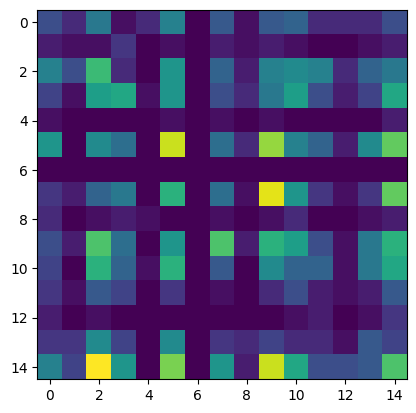

In [9]:
plt.imshow(mat)
mat[1,1]

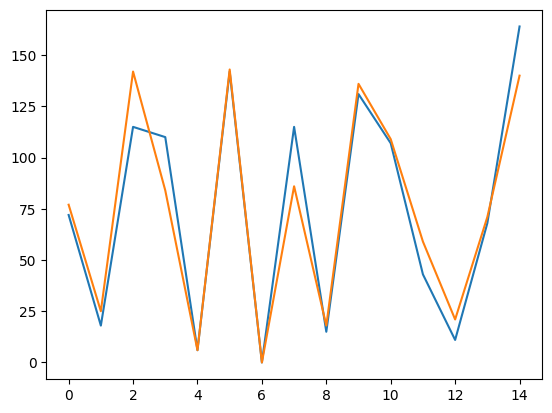

In [10]:
plt.plot(a1)
plt.plot(a2)

In [107]:
xy=np.array(xy)
xy.shape

(5175, 2)

In [109]:
xy[0]

array([295,   5])

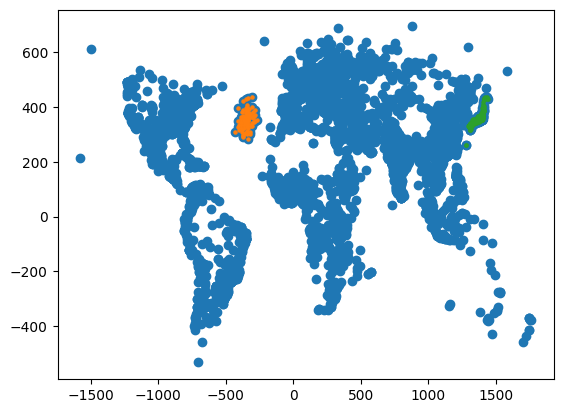

In [123]:
plt.scatter(xy[:,0],xy[:,1])
ainds=np.array(regions)=="Atlantis"
plt.scatter(xy[ainds,0],xy[ainds,1],s=5)
ainds=np.array(regions)=="Japan"
plt.scatter(xy[ainds,0],xy[ainds,1],s=5)

In [ ]:
ds=datasets.load_from_disk("./data/datasets/dist_1M_with_atlantis/")
ds["train"][0],

{'text': '<bos> d i s t ( c _ 2 4 9 8 , c _ 5 6 0 8 ) = 1 1 4 <eos>',
 'task_type': 'distance',
 'token_lengths': 25,
 'loss_mask': '0000000000000000000001111'}